# MMD figure (only 'Gauss' model)

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import timeit
import os
import pickle
from delfi.utils.viz import plot_pdf
from delfi.utils.delfi2snl import SNLprior

from lfimodels.snl_exps.util import save_results, load_results

from lfimodels.snl_exps.util import load_setup_gauss as load_setup
from lfimodels.snl_exps.util import load_gt_gauss as load_gt
from lfimodels.snl_exps.util import init_g_gauss as init_g


import snl.inference.mcmc as mcmc
import snl.inference.diagnostics.two_sample as two_sample
from snl.util import math

def sampl_snl(save_path, exp_id, rng, prior, obs_stats, init_pars, N=5000):

    fn = os.path.join(save_path, exp_id, 'SNL_posteriors')
    with open(fn + '.pkl', 'rb') as f:
        snl_posteriors = pickle.load(f)

    all_ps = []

    r = 1

    
    try:
        all_ps = np.load(os.path.join(save_path, exp_id, 'ps.npy'))
        assert np.all( all_ps[r].shape[0] == N for r in range(len(all_ps)) )
        print('loaded results successfully')
    except:
        print('failed to load results, re-sampling !')
        for network in snl_posteriors:

            print('\n')
            print('round r=' + str(r))
            print('\n')

            log_post = lambda t: network.eval([t, obs_stats]) + prior.eval(t)
            sampler = mcmc.SliceSampler(init_pars, log_post, thin=10)
            sampler.gen(100, rng=rng)  # burn in
            samples = sampler.gen(N, rng=rng)

            all_ps.append(samples)

            r += 1

    fn = os.path.join(save_path, exp_id, 'SNL_samples')
    np.save(fn, all_ps)

    return all_ps


def calc_all_mmds_snl(samples_true, samples_snl):
    """ only called for 'Gaussian' simulator """

    all_mmds = []
    ct = 0
    for samples in samples_snl:
        
        ct += 1
        
        print('\n round #' + str(ct) + '/' + str(len(samples_snl)))
        
        if np.any(np.isnan(samples)): # fail to sample n_sample times
            all_mmds.append(np.inf)
        else:            
            print('- computing MMD')
            scale = math.median_distance(samples_true)
            mmd = two_sample.sq_maximum_mean_discrepancy(samples, samples_true, scale=scale)
            if isinstance(mmd, np.ndarray):
                mmd = mmd.flatten()[0]
            all_mmds.append(mmd)
        
    return np.array(all_mmds).flatten()



def run_mmd_plots_snl(seed, model_id, save_path, exp_id, fig_path, N):

    model_id = 'gauss'

    
    # simulation setup
    setup_dict = load_setup()

    pars_true, _ = load_gt(generator=init_g(seed=seed))
    print('pars_true : ', pars_true)

    #_,_,posteriors, setup_dict = load_results(exp_id=exp_id, path=save_path)
    
    #obs_stats = posteriors[0].obs_stats # get full obs_stats (including noise) from parallel SNPE-C fits
    fn = os.path.join(save_path, exp_id, 'obs_stats_noise')
    obs_stats = np.load(fn + '.npy')
    
    print('obs_stats : ', obs_stats)

    prior = SNLprior(init_g(seed=seed).prior)

    rng = np.random
    rng.seed(seed)
    
    samples_snl = sampl_snl(save_path, exp_id, rng=rng, prior=prior, obs_stats=obs_stats.flatten(),init_pars=pars_true, N=N)    
    
    # mmd figure 
    dir = os.path.join(save_path, exp_id)
    if not os.path.exists(dir):
        os.makedirs(dir)
    samples_true = np.load(os.path.join('results/' + model_id, 'seed' + str(seed-10), 'samples.npy'))
    
    all_mmds = calc_all_mmds_snl(samples_true, samples_snl)
    
    print('all_mmds', all_mmds)
    
    np.save(os.path.join(save_path, exp_id, 'all_mmds_snl_N' + str(N)), 
            all_mmds)
        
    try:
        plt.figure(figsize=(8,5))
        plt.semilogx(np.arange(1, all_mmds.size+1,1) * setup_dict['n_train'], np.sqrt(all_mmds), 'kd:')
        plt.xlim([0.6*setup_dict['n_train'], (setup_dict['n_rounds']+2)*setup_dict['n_train']])
        plt.xlabel('Number of simulations (log scale)')
        plt.ylabel('maximum mean discrepancy')
        plt.savefig(fig_path + model_id + '_maf_snl' + '_N' + str(N) +'_mmds.pdf')
        plt.show()
    except:
        pass


/home/marcel/anaconda3/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7401 on context None
Mapped name None to device cuda: GeForce RTX 2080 (0000:42:00.0)


pars_true :  [-0.7 -2.9 -1.  -0.9  0.6]
obs_stats :  [ 19.61151036 -31.55715531 -11.24242725  -3.42318484 -23.35931062
  -2.2470625   -8.782498    28.20733131  16.13385812  -1.78944184
 -41.18584238  -7.01049097  12.18049786   7.41921009  15.67430014
   4.57712737  -5.72949977 -11.06805789   7.41040167  36.00939322
  -0.97071232 -25.4390672   11.69506607   2.06535088  -8.22809311
 -15.75543437  12.00527238  -3.36401699  -0.13285634 -22.5948446
  26.6762034   32.2716582    4.60598629  -2.42716377   9.61284093
 -17.83169674  -4.70603223 -11.06187348  -8.89195937 -21.4037538
 -28.46042883  -0.5844647    7.56853136   2.39511502   2.39616121
 -11.60163663   8.75625305  11.09440446 -12.31079435 -26.42209761
 -12.49200835  23.73649138  -0.44947218 -13.98104481 -14.67800691
 -18.24821408  -6.20997227  12.60725109 -17.2596336   19.67943057
 -10.02396753  13.09815336  -2.94612244  -8.11022492  23.62771609
  26.78497047  -9.18637345   4.38496256  17.20596663 -18.99262306
  18.32023691 -10.5547476

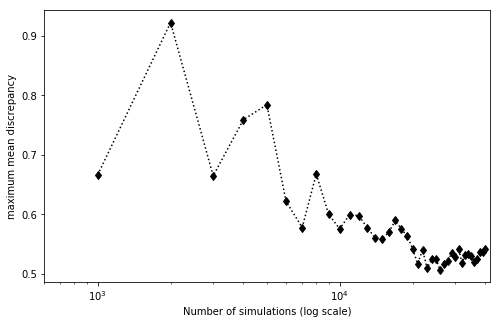

pars_true :  [-0.7 -2.9 -1.  -0.9  0.6]
obs_stats :  [ -0.82472297 -27.12915932  11.08273494   3.06742984  -7.49744776
   2.51731457 -13.80834578 -19.18339317  11.39981873 -18.63563617
 -10.09921418  23.33603486 -29.01627317  20.14162688  -0.97071232
 -30.11958762  -6.30169449 -12.86709059   2.34662382  -6.70485037
 -11.91071398   2.99141623  23.70044141  14.71561299   1.21610278
   5.33605035  30.45734284  -7.26964266   4.36637284  -1.3846915
 -12.20339322 -12.38061636  -0.13285634 -16.83319866 -10.66705204
  29.97217865  -2.0558091  -23.27178314   7.85842935 -10.0450197
 -11.53510851 -11.02276829  35.04762456  10.56298295   3.46781339
 -15.26675869  29.37851505  -1.55079133  18.58790334  36.49619563
   4.40715811 -13.59113812  10.25911789 -15.60676001 -16.23092589
   6.09607953 -13.46272945   7.8534767    5.1023113   -0.55443928
  19.17331705  19.00816492  -0.1043765  -11.71511675  -3.36401699
 -12.63367275 -10.15387356 -14.1525794   -8.74518762 -13.08277148
  23.65302107   1.6424459

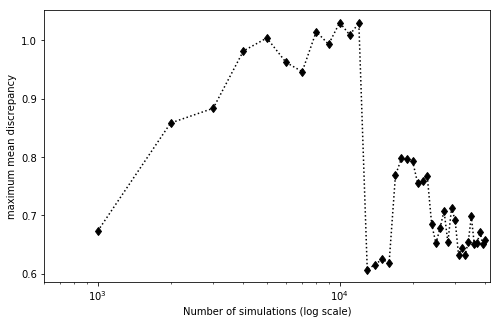

pars_true :  [-0.7 -2.9 -1.  -0.9  0.6]
obs_stats :  [ 30.81920523   2.783343     2.96095702  19.25537043   8.25585037
 -45.86364186   1.87390503  -2.62549539  14.90834115 -23.35149507
  -3.36401699 -16.22270082  14.81214846  -0.85367595 -23.38802184
  -3.50942847  -0.13285634  13.89201599 -13.06891412   4.11127047
  17.08401696 -17.81414192   4.66679917   2.04285881  10.8483732
   8.64905462   9.5312607   20.27909619  -6.69922158 -25.47193327
  29.05463032  14.85715819  -0.18991942   1.37322297   7.61831194
   6.51567132 -21.36426019 -20.26734727  -4.88773562  -0.44947218
 -13.57447332  33.27136996  -7.81975999  10.3176497   -2.21443267
  -2.94612244  12.04704738  -2.42716377   5.18259487  -3.42318484
 -30.4193804    8.75986487 -12.28418361 -10.67739727  25.88011725
  -5.01923781   9.62327541  -9.04428164  13.8103406   -3.40491986
   4.82694601   8.53880644 -13.14014561 -12.70305374   9.80318176
   1.65162205  -8.03533501  -6.14044421  -6.21649651  25.63958607
 -16.9519922  -10.099717

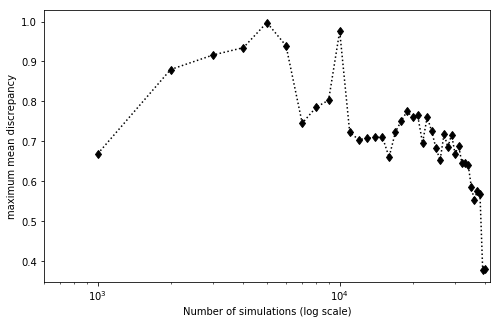

pars_true :  [-0.7 -2.9 -1.  -0.9  0.6]


FileNotFoundError: [Errno 2] No such file or directory: 'results/gauss_noisedims_v2/seed56/obs_stats_noise.npy'

In [2]:
model_id = 'gauss'
N = 1000

fig_path = 'results/'
save_path = 'results/' + model_id + '_noisedims_v2'

seeds = np.arange(52,62)
for seed in seeds:
    exp_id = 'seed'+str(seed)        
    run_mmd_plots_snl(seed=seed, model_id=model_id, save_path=save_path, exp_id=exp_id, fig_path=fig_path, N=N)